In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from itertools import product

warnings.filterwarnings("ignore")


In [45]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)
        df_all = df_all.fillna(0)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)

In [46]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("minmax", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("minmax", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: minmax
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)


## 3. Decision Tree

## Treinamento e Avaliação Inicial

Treinamento da Decision Tree com os hiperparâmetros principais do artigo e avaliação inicial no conjunto de validação.

In [47]:
# Defina o seed global para reprodutibilidade
np.random.seed(1)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

## 4. Cálculo do CCP Alpha para Pruning (cf=0.25)
# 4.1 Gerar caminho de pruning para várias ccp_alphas
tmp = DecisionTreeClassifier(
    criterion="entropy",
    random_state=1
)
path = tmp.cost_complexity_pruning_path(X_train, y_train_enc)

# 4.2 Selecionar alpha correspondente à impureza ~0.25
alpha = path.ccp_alphas[np.searchsorted(path.impurities, 0.25)]

## 5. Treino da Decision Tree (J48)
dt = DecisionTreeClassifier(
    criterion="entropy",
    random_state=1,
    ccp_alpha=alpha
)

print("Hiperparâmetros da Decision Tree:")
print(dt.fit(X_train, y_train_enc))


## 6. Avaliação
# 6.1 Métricas de Classificação Multiclasse
y_pred = dt.predict(X_val)
print("Acurácia:", accuracy_score(y_val_enc, y_pred))
print(classification_report(
    y_val_enc,
    y_pred,
    target_names=le.classes_,
    digits=4
))

print(path.ccp_alphas)


Hiperparâmetros da Decision Tree:
DecisionTreeClassifier(ccp_alpha=np.float64(0.03967872735272675),
                       criterion='entropy', random_state=1)
Acurácia: 0.9326056757293114
              precision    recall  f1-score   support

         DoS     0.9799    0.9636    0.9717      9186
       Probe     0.6736    0.9356    0.7833      2331
         R2L     0.0000    0.0000    0.0000       199
         U2R     0.0000    0.0000    0.0000        10
      normal     0.9645    0.9254    0.9445     13469

    accuracy                         0.9326     25195
   macro avg     0.5236    0.5649    0.5399     25195
weighted avg     0.9352    0.9326    0.9317     25195

[0.00000000e+00 0.00000000e+00 4.56292315e-06 1.07197549e-05
 1.59721415e-05 1.79088714e-05 1.88546561e-05 1.93501286e-05
 1.98456012e-05 1.98456012e-05 1.98456012e-05 1.98456012e-05
 1.98456012e-05 2.12517558e-05 2.15358538e-05 2.73361994e-05
 2.73361994e-05 2.73361994e-05 2.73361994e-05 2.73361994e-05
 2.73361994e-05 2

### Busca de Hiperparâmetros 

In [48]:
## 7. Busca de Hiperparâmetros (Grid Search)
# Definindo grade de busca usando o modelo padrão
# Listas de parâmetros para explorar
criterion_list = ['entropy', 'gini']
max_depth_list = [None, 10, 20, 30]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list = [1, 2, 4]
max_features_list = [None, 'sqrt', 'log2']
ccp_alpha_list = [0.25, 0.3, 0.4, 0.5, 0.75, 1.0]


# Lista para armazenar resultados
i = 0
results = []
for crit, depth, mss, msl, mf, alpha in product(criterion_list, max_depth_list, min_samples_split_list, min_samples_leaf_list, max_features_list, ccp_alpha_list
):
    dt = DecisionTreeClassifier(
        criterion=crit,
        max_depth=depth,
        min_samples_split=mss,
        min_samples_leaf=msl,
        max_features=mf,
        ccp_alpha=alpha,
        random_state=1
    )

    dt.fit(X_train, y_train_enc)
    y_pred = dt.predict(X_val)

    acc = accuracy_score(y_val_enc, y_pred)
    f1 = f1_score(y_val_enc, y_pred, average='macro')
    
    results.append({
        'criterion': crit,
        'max_depth': depth,
        'min_samples_split': mss,
        'min_samples_leaf': msl,
        'max_features': mf,
        'ccp_alpha': round(alpha,6),
        'accuracy': acc,
        'f1_macro': f1
    })

    i += 1

print(f"Testadas {i} combinações de hiperparâmetros")

# Exibir resultados em DataFrame
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
print(df_sorted.head(10))


Testadas 1728 combinações de hiperparâmetros
  criterion  max_depth  min_samples_split  min_samples_leaf max_features  \
0      gini       30.0                 10                 4         None   
1   entropy        NaN                  2                 2         None   
2   entropy        NaN                  2                 2         None   
3   entropy        NaN                  2                 2         None   
4   entropy        NaN                  2                 2         None   
5      gini       30.0                 10                 2         None   
6      gini       30.0                 10                 1         None   
7      gini       30.0                  5                 4         None   
8      gini       30.0                  5                 2         None   
9      gini       30.0                  5                 1         None   

   ccp_alpha  accuracy  f1_macro  
0       0.25  0.830601  0.346848  
1       0.50  0.830601  0.346848  
2       0.40 

## Melhor Modelo

In [33]:
# Treinar o melhor modelo encontrado
best_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    ccp_alpha=0.25,
    random_state=1
)
best_dt.fit(X_train, y_train_enc)

# Avaliar no conjunto de validação
y_pred = best_dt.predict(X_val)

# Métricas principais
accuracy = accuracy_score(y_val_enc, y_pred)
precision = precision_score(y_val_enc, y_pred, average='macro')
recall = recall_score(y_val_enc, y_pred, average='macro')
f1 = f1_score(y_val_enc, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred))

# Matriz de confusão e estatísticas derivadas
cm = confusion_matrix(y_val_enc, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))

# AUC-ROC
try:
    y_prob = best_dt.predict_proba(X_val)
    auc = roc_auc_score(y_val_enc, y_prob, multi_class='ovr', average='macro')
except:
    auc = None

# Exibição final
print("\n==== Avaliação Final - Decision Tree (Validação) ====")
print(f"{'Acurácia:':<30} {accuracy:.4f}")
print(f"{'F1-score (macro):':<30} {f1:.4f}")
print(f"{'Precisão (macro):':<30} {precision:.4f}")
print(f"{'Recall (macro / TPR):':<30} {recall:.4f}")
print(f"{'AUC-ROC:':<30} {auc:.4f}" if auc is not None else "AUC-ROC:                   Não aplicável")
print(f"{'RMSE:':<30} {rmse:.4f}")
print(f"{'FPR (média):':<30} {fpr:.4f}")
print(f"{'FNR (média):':<30} {fnr:.4f}")
print("==============================================")


==== Avaliação Final - Decision Tree (Validação) ====
Acurácia:                      0.8306
F1-score (macro):              0.3468
Precisão (macro):              0.3293
Recall (macro / TPR):          0.3691
AUC-ROC:                       0.7939
RMSE:                          1.1140
FPR (média):                   0.0580
FNR (média):                   0.6309


### Avaliação do Melhor Modelo

In [54]:
# Visualização da matriz de confusão multiclasse
y_val_labels = le.inverse_transform(y_val_enc)
y_pred_labels = le.inverse_transform(y_pred)

# Relatório detalhado por classe
report_dict = classification_report(
    y_val_labels,
    y_pred_labels,
    output_dict=True,
    digits=4
)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)


labels = sorted(pd.Series(y_val_labels).unique())
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - Decision Tree (Validação)")
plt.grid(False)
plt.tight_layout()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [25195, 22544]

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9243    0.9281    0.9262     13469
      attack     0.9170    0.9127    0.9148     11726

    accuracy                         0.9209     25195
   macro avg     0.9206    0.9204    0.9205     25195
weighted avg     0.9209    0.9209    0.9209     25195



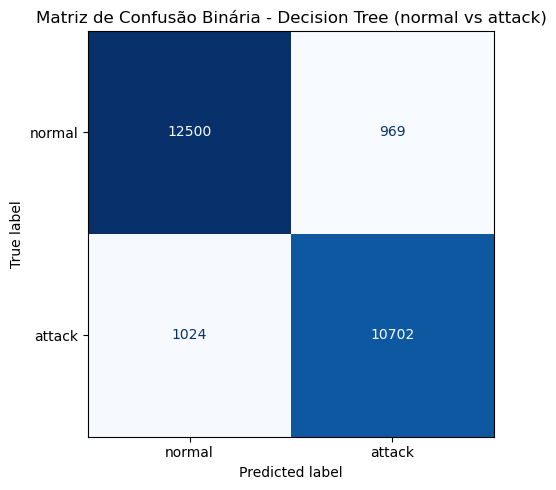

In [36]:
# Avaliação binária (normal vs ataque)
y_val_bin = pd.Series(y_val_labels).apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred_labels).apply(lambda x: 0 if x == "normal" else 1)

print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - Decision Tree (normal vs attack)")
plt.grid(False)
plt.tight_layout()
plt.show()

## Avaliação Final no Conjunto de Teste Real (KDDTest+)

O modelo DT selecionado é treinado com todos os dados de treino e avaliado no conjunto de teste real (`KDDTest+`). 

In [50]:
# Avaliação Final - Decision Tree (KDDTrain+ vs KDDTest+)


y_train_enc = le.fit_transform(y_train_final)
y_test_enc = le.transform(y_test_final)

# Treinar o melhor modelo encontrado
best_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    ccp_alpha=0.25,
    random_state=1
)
best_dt.fit(X_train_final, y_train_enc)

# Avaliar no conjunto de validação
y_pred = best_dt.predict(X_test_final)
y_prob = best_dt.predict_proba(X_test_final)



# Métricas principais
accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='macro')
recall = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred))

# Matriz de confusão e estatísticas derivadas
cm = confusion_matrix(y_test_enc, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))

# AUC-ROC
try:
    auc = roc_auc_score(y_test_enc, y_prob, multi_class='ovr', average='macro')
except:
    auc = None

print("\n==== Avaliação Final - Decision Tree (KDDTrain+ vs KDDTest+) ====")
print(f"{'Acurácia:':<30} {accuracy:.4f}")
print(f"{'F1-score (macro):':<30} {f1:.4f}")
print(f"{'Precisão (macro):':<30} {precision:.4f}")
print(f"{'Recall (macro / TPR):':<30} {recall:.4f}")
print(f"{'AUC-ROC:':<30} {auc:.4f}" if auc is not None else "AUC-ROC:                   Não aplicável")
print(f"{'RMSE:':<30} {rmse:.4f}")
print(f"{'FPR (média):':<30} {fpr:.4f}")
print(f"{'FNR (média):':<30} {fnr:.4f}")
print("==============================================")




==== Avaliação Final - Decision Tree (KDDTrain+ vs KDDTest+) ====
Acurácia:                      0.6655
F1-score (macro):              0.2997
Precisão (macro):              0.2685
Recall (macro / TPR):          0.3438
AUC-ROC:                       0.7370
RMSE:                          1.5111
FPR (média):                   0.1117
FNR (média):                   0.6562


### Relatório

Relatório de precisão, recall e F1-score para cada categoria no conjunto de teste real.

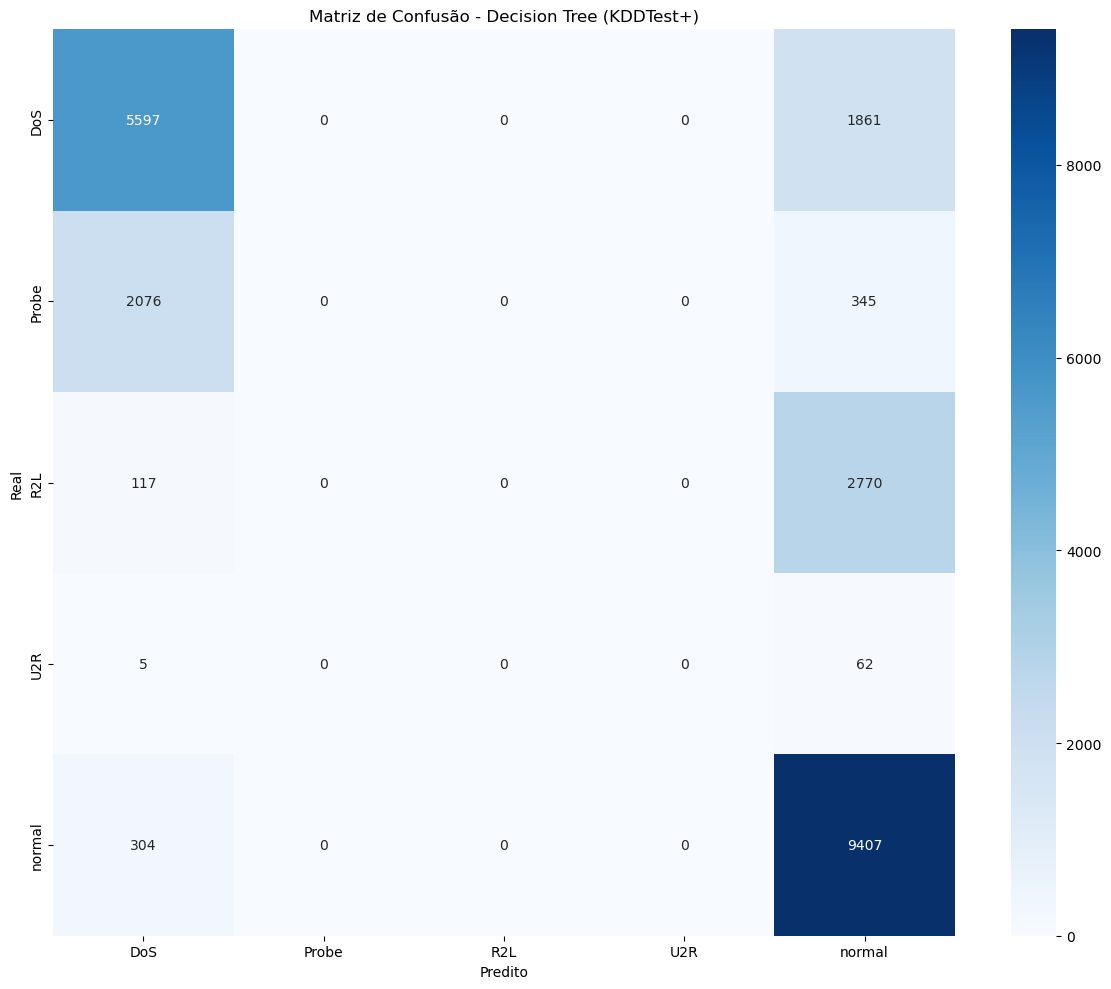

In [51]:
# Visualização da matriz de confusão multiclasse
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Decision Tree (KDDTest+)')
plt.tight_layout()
plt.show()



In [52]:
# Relatório detalhado por classe
y_test_labels = le.inverse_transform(y_test_enc)
y_pred_labels = le.inverse_transform(y_pred)
report_dict = classification_report(
    y_test_labels,
    y_pred_labels,
    output_dict=True,
    digits=4
)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)



              precision    recall  f1-score       support
DoS            0.691073  0.750469  0.719547   7458.000000
Probe          0.000000  0.000000  0.000000   2421.000000
R2L            0.000000  0.000000  0.000000   2887.000000
U2R            0.000000  0.000000  0.000000     67.000000
normal         0.651229  0.968695  0.778854   9711.000000
accuracy       0.665543  0.665543  0.665543      0.665543
macro avg      0.268460  0.343833  0.299680  22544.000000
weighted avg   0.509142  0.665543  0.573538  22544.000000


              precision    recall  f1-score       support
normal         0.651229  0.968695  0.778854   9711.000000
attack         0.962465  0.607418  0.744793  12833.000000
accuracy       0.763041  0.763041  0.763041      0.763041
macro avg      0.806847  0.788057  0.761823  22544.000000
weighted avg   0.828397  0.763041  0.759465  22544.000000


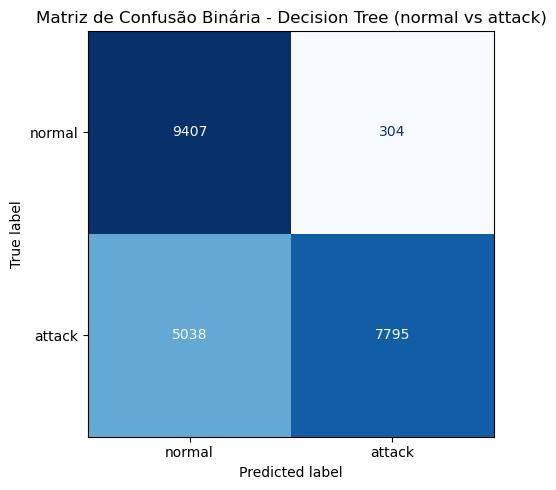

In [53]:
# Avaliação binária (normal vs ataque)
y_test_bin = pd.Series(y_test_labels).apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred_labels).apply(lambda x: 0 if x == "normal" else 1)

report_bin = classification_report(
    y_test_bin,
    y_pred_bin,
    target_names=["normal", "attack"],
    digits=4,
    output_dict=True
)
report_bin_df = pd.DataFrame(report_bin).transpose()
print(report_bin_df)

cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - Decision Tree (normal vs attack)")
plt.grid(False)
plt.tight_layout()
plt.show()